<a href="https://colab.research.google.com/github/monya-9/deep-learning-practice/blob/main/05_token_embedding_positional_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 토큰 임베딩 + 포지셔널 인코딩, LayerNorm + 잔차연결
📌 실습 목표

- 토큰 ID → 임베딩 변환

- 포지셔널 인코딩 구현 (Sinusoidal 방식)

- LayerNorm과 Residual Connection 적용

- 임베딩 + 포지셔널 인코딩 시각화

In [8]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [2]:
# ===== 1. Token Embedding Layer =====
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        return self.embedding(x)  # [batch, seq_len, embed_dim]

- 토큰 ID(정수)를 고정 길이 벡터로 변환
- 입력: [batch, seq_len] 형태의 정수 텐서
- 출력: [batch, seq_len, embed_dim] 형태의 실수 텐서

In [3]:
# ===== 2. Positional Encoding (Sinusoidal) =====
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

- 순서 정보(위치 인덱스)를 임베딩에 더함.
- 트랜스포머는 RNN처럼 순서를 기억하지 못하므로 sin/cos 주기 함수를 이용해 위치 인코딩을 추가.
- 수학적 아이디어
 - 짝수 인덱스: sin(position / 10000^(2i/d_model))
 - 홀수 인덱스: cos(position / 10000^(2i/d_model))
- register_buffer: 학습 파라미터로 취급하지 않고 모델과 함께 저장.

In [4]:
# ===== 3. LayerNorm + Residual =====
class ResidualLayerNorm(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, x, sublayer_out):
        return self.norm(x + sublayer_out)  # residual connection + norm

- 트랜스포머 블록의 핵심 패턴
  - 출력 = LayerNorm(입력 + 서브레이어 결과)
- 장점
  1. Residual Connection: 기울기 소실 방지, 정보 보존
  2. LayerNorm: 학습 안정성, 수렴 가속

In [6]:
# ===== 4. Demo =====
batch_size, seq_len, vocab_size, embed_dim = 2, 5, 100, 16

tokens = torch.randint(0, vocab_size, (batch_size, seq_len))  # random token IDs
print("Tokens:\n", tokens)

token_embed = TokenEmbedding(vocab_size, embed_dim)
pos_encoding = PositionalEncoding(embed_dim)
res_layernorm = ResidualLayerNorm(embed_dim)

# 1) Token → Embedding
embedded = token_embed(tokens)

# 2) Add Positional Encoding
embedded_with_pos = pos_encoding(embedded)

# 3) Example: apply residual connection with a dummy sublayer (e.g. FFN)
dummy_sublayer_output = embedded_with_pos * 0.5
output = res_layernorm(embedded_with_pos, dummy_sublayer_output)

print("Final Output Shape:", output.shape)

Tokens:
 tensor([[76, 19, 59, 49, 74],
        [49, 73, 90, 36, 72]])
Final Output Shape: torch.Size([2, 5, 16])


- 랜덤 토큰 시퀀스 생성([2, 50] 크기)
- 토큰 -> 임베딩 -> 위치 정보 추가
- 가짜 서브레이어 출력(0.5배 스케일)과 Residual + LayerNorm 적용

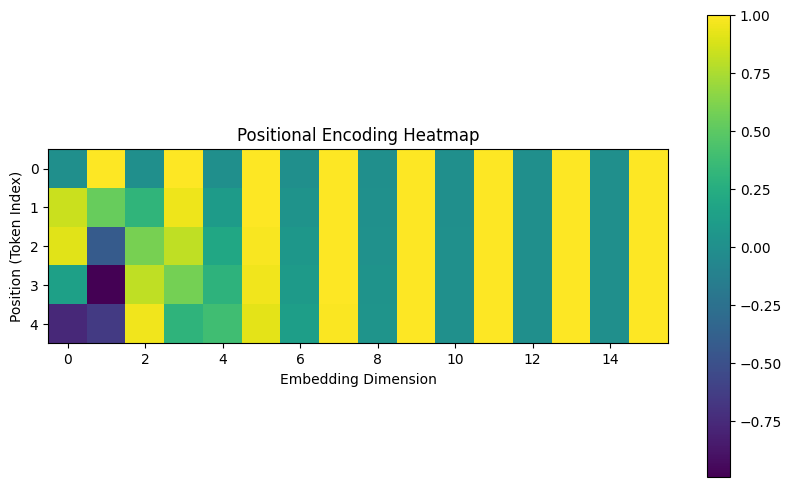

In [9]:
# ===== 5. 시각화 =====
pe_matrix = pos_encoding.pe[0, :seq_len].detach().numpy()
plt.figure(figsize=(10, 6))
plt.imshow(pe_matrix, cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position (Token Index)")
plt.show()

- 위치 인코딩 패턴이 주기적으로 변하는 모습을 Heatmap으로 확인
- 세로축 = 토큰 위치, 가로축 = 임베딩 차원